# Final project: Predicting NBA Rookie’s career

This it the report of our project 'Predicting NBA Rookie’s career', the authors are:

| Name                  | ID        | Email                                     |
|-----------------------|-----------|-------------------------------------------|
| Riccardo Corrente     | 1964746   | corrente.1964746@studenti.uniroma1.it     |
| Santiago Vessi        | 1958879   | vessi.1958879@studenti.uniroma1.it        |
| Pietro Sciabbarrasi   | 1970875   | sciabbarrasi.1970875@studenti.uniroma1.it |
| Francesco Sbordone    | 1969896   | sbordone.1969896@studenti.uniroma1.it     |
| Yao Wateba Appeti     | 1522685   | appeti.1522685@studenti.uniroma1.it       |

### Abstract

In the NBA, where competition reigns supreme, only the best players secure a spot on the court. Every team must carefully curate their roster, balancing competitiveness with fiscal responsibility, adhering to the league's salary caps. Choosing the right players becomes a strategic imperative for each franchise. As a new wave of rookie players enters the league every year, not all will rise to the occasion. Hence, it's crucial to anticipate and predict the potential of these newcomers. Our project aims to forecast the performance of the 2023 rookie class based on their first-year achievements.

### Proposed Method explained

The project idea was to start with an exploratory data analysis to identify any outliers that necessitated modifications to our dataset. The stat we wanted to predict for the rookies of the 2023 season was the Player Efficiency Rating (PER). PER is a per-minute rating that summarizes a player's statistical accomplishments in a single number.

Next, we would build a linear regression model using 80% of the dataset and then test its performance on the remaining 20%. The result obtained would be the subject of our next step. Additionally, we would explore another path, comparing by position and conducting a more in-depth analysis, using clustering algorithms to perform a more detailed analysis.

Finally, we would predict the rookies' PER with the models built before and evaluate the accuracy achieved.

## 0. Import Libraries

In [153]:
# Importing libraries
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
from collections import Counter
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns
import warnings
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import pickle
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## 1. OverView of the data

Our Datasets contains stats of players in NBA season for every year from 2010 to 2023.

We also have a rookies datasets which only shows the IDs of the rookies for a given season. A rookie is a new player who never played in The NBA, debuting in a certain season.

Our goal is to study the career of the player staring from his rookie years.

**N.B.: Paragraph 1.1 displays all the code executed for scraping data from the site and creating the DataFrames. However, to save time (as the procedure takes 5/6 minutes), you can skip running this section and simply load the pickled versions of the DataFrames into the workspace by executing just the [last cell of 1.1 paragraph](#pickles).**

### 1.1 Import Data

All the datasets are taken from this [site](www.basketball-reference.com), using scrapers to import data in order to be able to change starting year and ending year.

So at the end of the scraped operation we will have 3 datasets: 

- *df_basic*: which contains basic statistics for every player for a given season.
- *df_advanced*: which contains more advanced statistics for every player for a given season.
- *rookies_id*: the dataset containing all the rookies for a given year.

The final dataset (called *rookies_df*) will have all the basic statistics for every rookie of his first year in NBA and some advanced statistics (in particular we will consider **PER_mean**) of the entire career.

To do that we will merge the first 2 DataFrames, importing only a few useful advanced statistics, and calculating **PER_mean** for the entire career of a player. Then we will select only the rows relative to rookies first year playing in the NBA.

In [154]:
def scraper_basic_statistics(starting_year, ending_year):
    """Function to import the DataFrame with basic statistics for all the players for a given
    range of seasons

    Args:
        starting_year (int): starting year
        ending_year (int): ending year

    Returns:
        df: DataFrame
    """
    df = pd.DataFrame()
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Years", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find the table on the page
                table = soup.find('table')

                # Read the df
                df_season = pd.read_html(str(table))[0]
                df_season = df_season.drop(columns=["Rk"])

                df_season['Season'] = year # add season
                df_season.drop_duplicates(keep = False, inplace = True) # delete headers repeated
                
                # add the id cause it has to be read from another place, it's not in the table
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Extract ids from data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                df_season['ID'] = ids
                
                # Let's eliminate the rows related to players who have changed teams during the season,
                # keeping only the row related to the statistics of the 2 or more teams they have played for.
                condition = (df_season['Tm'] != 'TOT') & df_season.duplicated(subset=['Player', 'Season'], keep=False)

                # Select only useful rows
                df_season = df_season.loc[~condition]
                
                # concat
                df = pd.concat([df, df_season])
                time.sleep(1)
            
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
    
    columns_float = ['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
                    'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
    
    df[columns_float] = df[columns_float].astype(float)
    
    columns_int = ['G', 'Age', 'GS']
    df[columns_int] = df[columns_int].astype(int)
    
    return df

In [155]:
def scraper_advanced_statistics(starting_year, ending_year):
    """Function to import the DataFrame with advanced statistics for all the players for a given
    range of seasons

    Args:
        starting_year (int): starting year
        ending_year (int): ending year

    Returns:
        df: DataFrame
    """
    df = pd.DataFrame()
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Years", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find the table on the page
                table = soup.find('table')

                # Read the df
                df_season = pd.read_html(str(table))[0]
                df_season = df_season.drop(columns=['Unnamed: 19', "Unnamed: 24", "Rk"])
                df_season['Season'] = year # add season
                df_season.drop_duplicates(keep = False, inplace = True) # delete headers repeated
                
                # add the id cause it has to be read from another place, it's not in the table
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Extract ids from data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                df_season['ID'] = ids
                
                # Let's eliminate the rows related to players who have changed teams during the season,
                # keeping only the row related to the statistics of the 2 or more teams they have played for.
                condition = (df_season['Tm'] != 'TOT') & df_season.duplicated(subset=['Player', 'Season'], keep=False)

                # Select only useful rows
                df_season = df_season.loc[~condition]
                
                # concat
                df = pd.concat([df, df_season])
                time.sleep(1)
            
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
        
    columns_float = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
                    'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
    df[columns_float] = df[columns_float].astype(float)
    
    columns_int = ['G', 'Age', 'MP']
    df[columns_int] = df[columns_int].astype(int)

    return df

In [156]:
df_basic = scraper_basic_statistics(2010, 2023)
df_basic.info()

Processing Years:   0%|          | 0/14 [00:00<?, ?year/s]

Processing Years: 100%|██████████| 14/14 [00:41<00:00,  2.94s/year]

<class 'pandas.core.frame.DataFrame'>
Index: 7056 entries, 0 to 704
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7056 non-null   object 
 1   Pos     7056 non-null   object 
 2   Age     7056 non-null   int32  
 3   Tm      7056 non-null   object 
 4   G       7056 non-null   int32  
 5   GS      7056 non-null   int32  
 6   MP      7056 non-null   float64
 7   FG      7056 non-null   float64
 8   FGA     7056 non-null   float64
 9   FG%     7022 non-null   float64
 10  3P      7056 non-null   float64
 11  3PA     7056 non-null   float64
 12  3P%     6378 non-null   float64
 13  2P      7056 non-null   float64
 14  2PA     7056 non-null   float64
 15  2P%     6984 non-null   float64
 16  eFG%    7022 non-null   float64
 17  FT      7056 non-null   float64
 18  FTA     7056 non-null   float64
 19  FT%     6746 non-null   float64
 20  ORB     7056 non-null   float64
 21  DRB     7056 non-null   float64
 22  TRB   

In [157]:
df_basic.tail(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID
693,James Wiseman,C,21,TOT,45,22,19.3,4.2,7.5,0.558,0.1,0.4,0.200,4.1,7.1,0.580,0.563,1.5,2.2,0.701,1.6,4.3,5.9,0.7,0.2,0.6,1.1,2.4,10.0,2023,wisemja01
696,Christian Wood,C,27,DAL,67,17,25.9,5.9,11.5,0.515,1.6,4.2,0.376,4.3,7.3,0.594,0.583,3.2,4.2,0.772,1.3,6.0,7.3,1.8,0.4,1.1,1.8,2.5,16.6,2023,woodch01
697,Delon Wright,PG,30,WAS,50,14,24.4,2.8,5.8,0.474,0.8,2.4,0.345,1.9,3.4,0.564,0.545,1.0,1.2,0.867,1.2,2.4,3.6,3.9,1.8,0.3,0.9,1.2,7.4,2023,wrighde01
698,McKinley Wright IV,PG,24,DAL,27,1,12.4,1.7,3.6,0.469,0.3,1.0,0.321,1.4,2.6,0.529,0.515,0.5,0.7,0.684,0.3,1.4,1.7,2.1,0.3,0.2,0.7,0.9,4.2,2023,wrighmc01
699,Gabe York,SG,29,IND,3,0,18.7,2.7,7.0,0.381,2.0,6.0,0.333,0.7,1.0,0.667,0.524,0.7,0.7,1.000,0.0,2.0,2.0,1.7,0.7,0.0,0.0,1.7,8.0,2023,yorkga01
700,Thaddeus Young,PF,34,TOR,54,9,14.7,2.0,3.7,0.545,0.1,0.6,0.176,1.9,3.0,0.622,0.561,0.3,0.5,0.692,1.3,1.8,3.1,1.4,1.0,0.1,0.8,1.6,4.4,2023,youngth01
701,Trae Young,PG,24,ATL,73,73,34.8,8.2,19.0,0.429,2.1,6.3,0.335,6.1,12.7,0.476,0.485,7.8,8.8,0.886,0.8,2.2,3.0,10.2,1.1,0.1,4.1,1.4,26.2,2023,youngtr01
702,Omer Yurtseven,C,24,MIA,9,0,9.2,1.8,3.0,0.593,0.3,0.8,0.429,1.4,2.2,0.650,0.648,0.6,0.7,0.833,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4,2023,yurtsom01
703,Cody Zeller,C,30,MIA,15,2,14.5,2.5,3.9,0.627,0.0,0.1,0.000,2.5,3.8,0.649,0.627,1.6,2.3,0.686,1.7,2.6,4.3,0.7,0.2,0.3,0.9,2.2,6.5,2023,zelleco01
704,Ivica Zubac,C,25,LAC,76,76,28.6,4.3,6.8,0.634,0.0,0.0,0.000,4.3,6.7,0.637,0.634,2.2,3.1,0.697,3.1,6.8,9.9,1.0,0.4,1.3,1.5,2.9,10.8,2023,zubaciv01


In [158]:
starting_year = 2010
ending_year = 2023

df_advanced = scraper_advanced_statistics(starting_year=starting_year, ending_year=ending_year)
df_advanced.info()

Processing Years: 100%|██████████| 14/14 [01:07<00:00,  4.80s/year]

<class 'pandas.core.frame.DataFrame'>
Index: 7056 entries, 0 to 704
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7056 non-null   object 
 1   Pos     7056 non-null   object 
 2   Age     7056 non-null   int32  
 3   Tm      7056 non-null   object 
 4   G       7056 non-null   int32  
 5   MP      7056 non-null   int32  
 6   PER     7054 non-null   float64
 7   TS%     7023 non-null   float64
 8   3PAr    7022 non-null   float64
 9   FTr     7022 non-null   float64
 10  ORB%    7054 non-null   float64
 11  DRB%    7054 non-null   float64
 12  TRB%    7054 non-null   float64
 13  AST%    7054 non-null   float64
 14  STL%    7054 non-null   float64
 15  BLK%    7054 non-null   float64
 16  TOV%    7027 non-null   float64
 17  USG%    7054 non-null   float64
 18  OWS     7056 non-null   float64
 19  DWS     7056 non-null   float64
 20  WS      7056 non-null   float64
 21  WS/48   7054 non-null   float64
 22  OBPM  

In [159]:
df_advanced[df_advanced['Player'] == "LeBron James"].tail(10)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,ID
307,LeBron James,PF,29,MIA,77,2902,29.3,0.649,0.226,0.432,3.6,18.9,11.5,32.0,2.2,0.8,14.4,31.0,12.3,3.7,15.9,0.264,7.8,1.1,8.8,7.9,2014,jamesle01
303,LeBron James,SF,30,CLE,69,2493,25.9,0.577,0.265,0.413,2.4,16.6,9.6,38.6,2.3,1.6,15.3,32.3,7.4,2.9,10.4,0.199,6.1,1.0,7.1,5.7,2015,jamesle01
276,LeBron James,SF,31,CLE,76,2709,27.5,0.588,0.199,0.347,4.7,18.8,11.8,36.0,2.0,1.5,13.2,31.4,9.6,4.0,13.6,0.242,7.0,2.0,9.0,7.5,2016,jamesle01
281,LeBron James,SF,32,CLE,74,2794,27.0,0.619,0.254,0.395,4.0,20.7,12.6,41.3,1.6,1.3,16.1,30.0,9.8,3.0,12.9,0.221,6.4,1.2,7.6,6.7,2017,jamesle01
316,LeBron James,PF,33,CLE,82,3026,28.6,0.621,0.257,0.336,3.7,22.3,13.1,44.4,1.9,2.0,16.1,31.6,11.0,3.0,14.0,0.221,7.3,1.4,8.7,8.2,2018,jamesle01
347,LeBron James,SF,34,LAL,55,1937,25.6,0.588,0.299,0.382,3.1,21.3,12.4,39.4,1.7,1.4,13.3,31.6,4.7,2.6,7.2,0.179,6.4,1.7,8.0,4.9,2019,jamesle01
332,LeBron James,PG,35,LAL,67,2316,25.5,0.577,0.326,0.292,3.2,21.5,12.4,49.1,1.6,1.4,15.1,31.5,6.2,3.6,9.8,0.204,6.6,1.8,8.4,6.1,2020,jamesle01
341,LeBron James,PG,36,LAL,45,1504,24.2,0.602,0.346,0.310,2.2,23.6,12.9,41.8,1.6,1.5,15.2,31.9,3.0,2.6,5.6,0.179,5.9,2.3,8.1,3.8,2021,jamesle01
381,LeBron James,C,37,LAL,56,2084,26.2,0.619,0.367,0.275,3.3,20.4,11.8,30.6,1.7,2.5,12.5,32.3,5.2,2.3,7.5,0.172,6.9,0.8,7.7,5.1,2022,jamesle01
317,LeBron James,PF,38,LAL,55,1954,23.9,0.583,0.309,0.268,3.7,20.8,12.5,33.5,1.2,1.4,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0,2023,jamesle01


In [160]:
print(df_basic.shape)
print(df_advanced.shape)

(7056, 31)
(7056, 28)


In [161]:
merged_df = pd.merge(df_basic, df_advanced[['PER', 'ID', 'Season', 'Player', 'WS', 'WS/48']], on=['ID', 'Season', 'Player'])
merged_df.sort_values(by=['ID', 'Season']).head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053
5372,Precious Achiuwa,PF,21,MIA,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,2.0,3.7,0.546,0.544,0.9,1.8,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,2021,achiupr01,14.2,1.3,0.085
5912,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2022,achiupr01,12.7,2.5,0.070
6517,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,0.485,0.5,2.0,0.269,3.0,5.4,0.564,0.521,1.6,2.3,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2,2023,achiupr01,15.2,2.2,0.093
1372,Quincy Acy,PF,22,TOR,29,0,11.8,1.4,2.6,0.560,0.0,0.1,0.500,1.4,2.5,0.562,0.567,1.1,1.3,0.816,1.0,1.6,2.7,0.4,0.4,0.5,0.6,1.8,4.0,2013,acyqu01,15.9,1.1,0.157
1839,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,0.468,0.1,0.2,0.267,1.0,2.0,0.492,0.482,0.6,0.8,0.660,1.1,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,2014,acyqu01,10.1,1.5,0.086
2319,Quincy Acy,PF,24,NYK,68,22,18.9,2.2,4.9,0.459,0.3,0.9,0.300,2.0,4.0,0.494,0.486,1.1,1.4,0.784,1.2,3.3,4.4,1.0,0.4,0.3,0.9,2.2,5.9,2015,acyqu01,11.9,1.7,0.063
2811,Quincy Acy,PF,25,SAC,59,29,14.8,2.0,3.6,0.556,0.3,0.8,0.388,1.7,2.8,0.606,0.600,0.8,1.2,0.735,1.1,2.1,3.2,0.5,0.5,0.4,0.5,1.7,5.2,2016,acyqu01,14.7,2.5,0.137


In [162]:
def rookies_id(starting_year, ending_year):
    """Function to extract rookies' ids for every year in a given range of seasons

    Args:
        starting_year (int): starting year
        ending_year (int): ending year

    Returns:
        dict: dictionary with rookies' ids for every season
    """
    rookies_per_year = {}
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Rookies", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_rookies.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')
                    
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Estrai i valori dell'attributo data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                
                rookies_per_year[year] = ids
                time.sleep(1)
                
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
            
    return rookies_per_year

In [163]:
rookies_id = rookies_id(starting_year=starting_year, ending_year=ending_year)

Processing Rookies: 100%|██████████| 14/14 [00:25<00:00,  1.85s/year]


In [164]:
rookies_id[2010][:10]

['anderda03',
 'anderan02',
 'pendeje02',
 'beaubro01',
 'blairde01',
 'brockjo01',
 'brownde04',
 'budinch01',
 'carrode01',
 'casspom01']

Adding `PER_mean` columns which represents the value of PER of the entire career of a certain player in NBA.

In [165]:
merged_df['PER'] = merged_df['PER'].astype(float)
merged_df[merged_df['ID'] == "abrinal01"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053


In [166]:
mean_PER = merged_df.groupby('ID')['PER'].mean().round(2)
# Let's calculate the mean for 'PER' column
merged_df = pd.merge(merged_df, mean_PER, on='ID', how='left', suffixes=('', '_mean'))
merged_df[merged_df['ID'] == "abrinal01"].head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096,8.47
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094,8.47
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053,8.47


Let's start the process to select only the rows relative to rookie's year for each player.

In [167]:
rookies_id

def inverted_rookies(dic):
    """
    Function to invert a dictionary.
    """
    inverted_rookies = {}
    for key in dic.keys():
        for id in dic[key]:
            inverted_rookies[id] = key
    return inverted_rookies

In [168]:
# Let's invert rookies_id to have ids as keys and years of each rookie as value.
inv_rookies = inverted_rookies(rookies_id)
# Convert it in a DataFrame
inv_rookies = pd.DataFrame(list(inv_rookies.items()), columns=['ID', 'Season'])
inv_rookies.head(10)

,ID,Season
0,anderda03,2010
1,anderan02,2010
2,pendeje02,2010
3,beaubro01,2010
4,blairde01,2010
5,brockjo01,2010
6,brownde04,2010
7,budinch01,2010
8,carrode01,2010
9,casspom01,2010


Let's join `inv_rookies` with `merged_df` on `ID` and `Season` to select only the rookies' rows.

In [169]:
rookies_df = pd.merge(merged_df, inv_rookies, on=['ID', 'Season'])
rookies_df.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.50
1,Antonio Anderson,SF,24,OKC,1,0,15.0,1.0,3.0,0.333,0.0,0.0,NaN,1.0,3.0,0.333,0.333,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2010,anderan02,-1.7,0.0,-0.104,-1.70
2,Jeff Ayres,C,22,POR,39,4,10.4,1.1,1.7,0.662,0.0,0.0,NaN,1.1,1.7,0.662,0.662,0.5,0.5,0.900,0.6,1.9,2.5,0.0,0.2,0.4,0.3,1.9,2.7,2010,pendeje02,12.1,1.3,0.156,12.30
3,Rodrigue Beaubois,PG,21,DAL,56,16,12.5,2.8,5.3,0.518,0.8,2.0,0.409,2.0,3.4,0.582,0.594,0.8,0.9,0.808,0.2,1.2,1.4,1.3,0.5,0.2,1.0,1.5,7.1,2010,beaubro01,18.5,2.0,0.134,13.95
4,DeJuan Blair,PF,20,SAS,82,23,18.2,3.4,6.0,0.556,0.0,0.0,0.000,3.4,6.0,0.558,0.556,1.1,2.0,0.547,2.4,4.0,6.4,0.8,0.6,0.5,1.4,2.7,7.8,2010,blairde01,17.7,4.6,0.147,13.91
5,Jon Brockman,PF,22,SAC,52,4,12.6,1.1,2.0,0.534,0.0,0.0,NaN,1.1,2.0,0.534,0.534,0.7,1.2,0.597,2.0,2.1,4.1,0.4,0.3,0.1,0.4,2.2,2.8,2010,brockjo01,12.4,1.7,0.125,9.53
6,Derrick Brown,SF,22,CHA,57,0,9.4,1.2,2.6,0.463,0.0,0.1,0.286,1.2,2.5,0.471,0.469,0.8,1.3,0.667,0.5,0.8,1.4,0.3,0.4,0.2,0.3,0.9,3.3,2010,brownde04,12.6,1.3,0.114,13.40
7,Chase Budinger,SF,21,HOU,74,4,20.1,3.4,7.6,0.441,1.2,3.4,0.369,2.1,4.3,0.497,0.522,0.9,1.2,0.770,0.5,2.5,3.0,1.2,0.5,0.1,0.6,1.1,8.9,2010,budinch01,14.1,3.1,0.100,12.63
8,DeMarre Carroll,SF,23,MEM,71,1,11.2,1.2,3.1,0.396,0.0,0.1,0.000,1.2,3.0,0.407,0.396,0.5,0.7,0.623,0.7,1.4,2.1,0.5,0.4,0.1,0.3,1.5,2.9,2010,carrode01,8.5,0.5,0.031,12.08
9,Omri Casspi,SF,21,SAC,77,31,25.1,3.9,8.7,0.446,1.0,2.6,0.369,2.9,6.1,0.480,0.502,1.5,2.3,0.672,1.0,3.6,4.5,1.2,0.7,0.2,1.3,1.6,10.3,2010,casspom01,13.0,2.5,0.063,13.12


We can save all the DataFrames created as pickle files, allowing us to load them into the workspace without the need to scrape them from the website each time, thus saving time.

In [170]:
merged_df.to_pickle('merged_df.pkl')
rookies_df.to_pickle('rookies_df.pkl')
df_basic.to_pickle('df_basic.pkl')
df_advanced.to_pickle('df_advanced.pkl')

---

It is possible to avoid running all the code above and just load the .pkl files in the workspace without wasting time to scrape data from the website.

In [243]:
# loading DataFrames into the workspace
merged_df = pd.read_pickle('merged_df.pkl')
rookies_df = pd.read_pickle('rookies_df.pkl')
df_basic = pd.read_pickle('df_basic.pkl')
df_advanced = pd.read_pickle('df_advanced.pkl')

<div id="pickles"></div>


### 1.2 Features

Now, we will analyze the `rookies_df` DataFrame, which will be our focus for the remainder of the project.

In [244]:
rookies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    1250 non-null   object 
 1   Pos       1250 non-null   object 
 2   Age       1250 non-null   int32  
 3   Tm        1250 non-null   object 
 4   G         1250 non-null   int32  
 5   GS        1250 non-null   int32  
 6   MP        1250 non-null   float64
 7   FG        1250 non-null   float64
 8   FGA       1250 non-null   float64
 9   FG%       1229 non-null   float64
 10  3P        1250 non-null   float64
 11  3PA       1250 non-null   float64
 12  3P%       1080 non-null   float64
 13  2P        1250 non-null   float64
 14  2PA       1250 non-null   float64
 15  2P%       1211 non-null   float64
 16  eFG%      1229 non-null   float64
 17  FT        1250 non-null   float64
 18  FTA       1250 non-null   float64
 19  FT%       1104 non-null   float64
 20  ORB       1250 non-null   floa

For every year for both rookies and players, here are the features in the dataset:

- **Player**: Name of the player.
- **Pos**: Position of the player.
- **Age**: Age during their rookie year.
- **Tm**: Rookie's team during his first year.
- **G**: Number of games played.
- **MP**: Minutes played per game.
- **FG, FGA**: Field goals made and attempted.
- **3P, 3PA**: Three-point field goals made and attempted.
- **2P, 2PA**: Two-point field goals made and attempted.
- **FT, FTA**: Free throws made and attempted.
- **TRB**: Total rebounds.
- **DRB**: Defensive rebounds.
- **ORB**: Offensive rebounds.
- **AST**: Assists.
- **STL**: Steals.
- **BLK**: Blocks.
- **PF**: Personal fouls.
- **PTS**: Points per game.
- **FG%**, **3P%**,**2P%**, **FT%**, **eFG%**: Shooting percentages.
- **ID**: Unique identifier for the player.
- **Season**: Season Played.
- **PER**: Player Efficiency Rating for the first NBA year. A statistical measure which attempts to collect or boil down all of a player's contributions into one number.
- **PER_mean**: Player Efficiency Rating for the entire career of a player.

### 1.3 Organize our  data

We can get players or rookies from a particular year.

In [245]:
def get_players_data(year, player_id = "all"):
    """
    Return the dataset of a particular year for all players or a specific one.
    """
    if player_id == "all":
        return merged_df[merged_df['Season'] == year]
    
    else:
        return merged_df[(merged_df['Season'] == year) & (merged_df['ID'] == player_id)]

def get_rookies_data_at_draft(year):
    """
    Return the dataset of a particular year for  only rookies drafted that year
    """
    return rookies_df[rookies_df['Season'] == year]


def get_all_rookies_ids(start_year, end_year):
    rookies_ids = []
    for year in range(start_year, end_year):
        if year != 2016:
            ids = get_rookies_data_at_draft['ID'].tolist()
            rookies_ids.extend(ids)
    return list(set(rookies_ids))

In [246]:
players_2014 = get_players_data(2014, 'acyqu01')
players_2014.head(5)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
1839,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,0.468,0.1,0.2,0.267,1.0,2.0,0.492,0.482,0.6,0.8,0.66,1.1,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,2014,acyqu01,10.1,1.5,0.086,10.79


## 2. Data Preprocessing

### 2.1 Standadize Player roles

Cleaning positions, considering only the most important of them.

In [247]:
Counter(rookies_df['Pos'].tolist())

Counter({'SG': 336,
         'PG': 249,
         'PF': 245,
         'SF': 231,
         'C': 183,
         'SG-SF': 2,
         'PF-SF': 1,
         'C-PF': 1,
         'SF-SG': 1,
         'SG-PG': 1})

In [248]:
#Defining a custom function to standardize roles
def standadize_role(role):
    roles = {
        "SG-SF": "SG",
        "SF-SG": "SF",
        "SG-PG": "SG",
        "PF-SF": "PF",
        "C-PF": "C",
        "SF-PF": "SF",
        "PF-C": "PF",
        "PG-SG":"PG",
        "SG-PG-SF":"SG",
        "SF-C":"SF"
    }
    return roles.get(role, role)

In [249]:
rookies_df['Pos'] = rookies_df['Pos'].apply(standadize_role)
Counter(rookies_df['Pos'].tolist())

Counter({'SG': 339, 'PG': 249, 'PF': 246, 'SF': 232, 'C': 184})

Let's plot a scatterplot of the `PER_mean` values to understand their distribution. We can observe that the mean is around 15, as mentioned earlier.

<Axes: ylabel='PER_mean'>

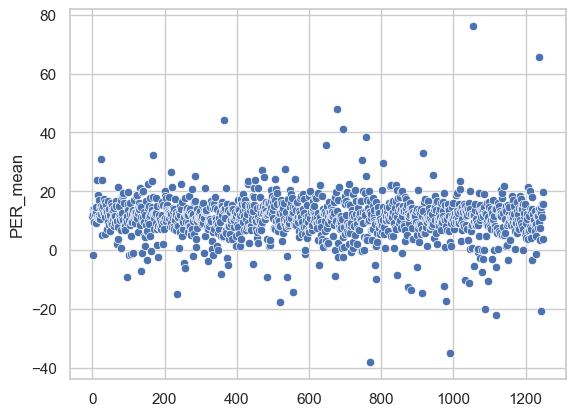

In [250]:
sns.scatterplot(rookies_df["PER_mean"])

We will remove players who played a very low number of games (<10), those who have a PER_mean above 40 and player with a PER_mean below 0.

In [251]:
rookies_df=rookies_df[rookies_df["PER_mean"]>=0 | (rookies_df["Season"]==2023)]
rookies_df=rookies_df[(rookies_df["G"] > 10) | (rookies_df["Season"]==2023)]
rookies_df=rookies_df[(rookies_df["PER_mean"] <40)]

Let's plot the scatterplot again-.

<Axes: ylabel='PER_mean'>

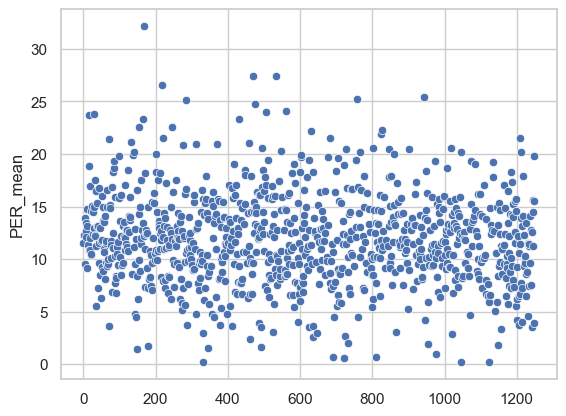

In [252]:
sns.scatterplot(rookies_df["PER_mean"])

In [253]:
rookies_df.describe().round(2) # 955 players remaining

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,WS,WS/48,PER_mean
count,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,872.00,955.00,955.00,953.00,955.00,955.00,955.00,942.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00
mean,22.01,43.43,12.66,15.23,2.12,4.88,0.43,0.51,1.56,0.29,1.61,3.32,0.48,0.48,0.87,1.22,0.71,0.69,1.89,2.58,1.25,0.48,0.31,0.85,1.45,5.61,2016.98,11.18,0.96,0.05,11.89
std,2.21,22.42,20.18,7.80,1.45,3.18,0.08,0.51,1.40,0.12,1.24,2.46,0.10,0.08,0.78,1.04,0.15,0.60,1.22,1.70,1.27,0.34,0.33,0.65,0.74,3.86,3.98,4.13,1.40,0.07,4.34
min,19.00,1.00,0.00,2.00,0.10,0.50,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,2010.00,-0.90,-2.10,-0.22,0.20
25%,20.00,23.00,0.00,9.20,1.10,2.60,0.38,0.10,0.50,0.25,0.75,1.60,0.42,0.43,0.40,0.50,0.63,0.30,1.00,1.30,0.50,0.30,0.10,0.40,0.90,2.90,2014.00,8.50,0.10,0.01,9.20
50%,22.00,42.00,2.00,13.90,1.70,4.00,0.42,0.40,1.30,0.31,1.20,2.70,0.48,0.48,0.70,0.90,0.73,0.50,1.60,2.20,0.80,0.40,0.20,0.70,1.40,4.60,2017.00,11.00,0.50,0.05,11.69
75%,23.00,63.00,16.00,20.10,2.80,6.30,0.47,0.80,2.30,0.36,2.10,4.30,0.54,0.53,1.10,1.60,0.80,0.90,2.50,3.40,1.60,0.60,0.40,1.10,1.95,7.40,2020.00,13.70,1.40,0.10,14.38
max,35.00,82.00,82.00,41.00,8.80,17.20,0.73,3.00,7.90,1.00,8.50,16.50,1.00,0.77,6.20,8.50,1.00,3.40,8.80,12.10,8.30,3.00,2.50,4.00,5.00,22.50,2023.00,27.70,9.80,0.32,32.18


## 3. Data Analysis

In this section, we delve into an analysis of the dataset, aiming to extract valuable insights and uncover patterns that contribute to a deeper understanding of the underlying information.

Our exploration will focus on key statistics such as Points (PTS), Assists (AST), and Total Rebounds (TRB) for each rookie. To provide a good view, we will utilize a variety of visualization techniques, including histograms, correlation matrices, scatterplots, and boxplots. We will also understand correlation between the features of the dataset.

### 3.1 Histograms of Points, Rebounds and Assists per game

In [254]:
def plot(df):
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

    # Points per game distribution
    sns.histplot(df['PTS'], kde=True, ax=axes[0, 0], bins=30, color='skyblue')
    axes[0, 0].set_title('Distribution of Points per Game')

    # Rebounds per game distribution
    sns.histplot(df['TRB'], kde=True, ax=axes[0, 1], bins=30, color='lightgreen')
    axes[0, 1].set_title('Distribution of Rebounds per Game')

    # Assists per game distribution
    sns.histplot(df['AST'], kde=True, ax=axes[0, 2], bins=30, color='salmon')
    axes[0, 2].set_title('Distribution of Assists per Game')

    # Scatter plot of Points vs Rebounds
    sns.scatterplot(x='PTS', y='TRB', data=df, ax=axes[1, 0], color='purple')
    axes[1, 0].set_title('Points vs Rebounds')

    # Scatter plot of Points vs Assists
    sns.scatterplot(x='PTS', y='AST', data=df, ax=axes[1, 1], color='orange')
    axes[1, 1].set_title('Points vs Assists')

    # Correlation heatmap
    corr = df[['PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1, 2])
    axes[1, 2].set_title('Correlation Heatmap')

    plt.tight_layout()
    plt.show()

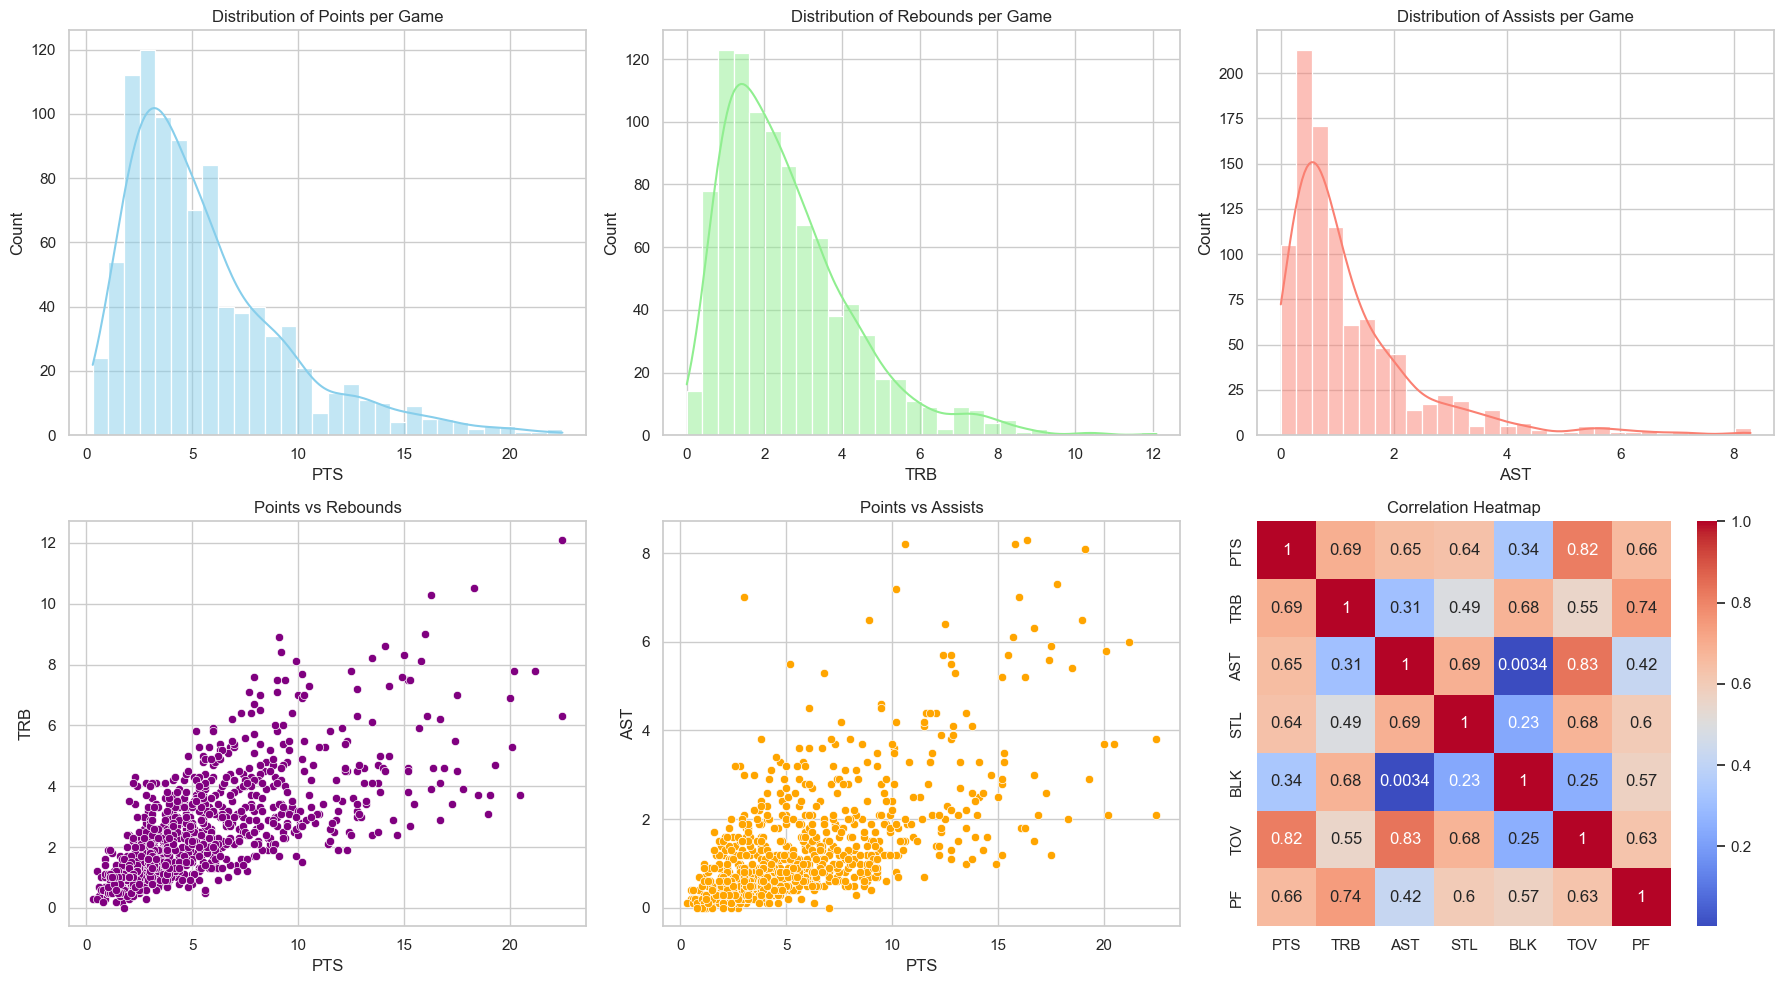

In [255]:
plot(rookies_df)

##### Histogram Observations:





**Points Per Game (PTS)**: The distribution is right-skewed, meaning most players score below the average, with a few high-scoring outliers.


**Assists Per Game (AST)**: Similar to points, the distribution is right-skewed, with most players recording fewer assists.

**Rebounds Per Game (TRB)**: This distribution also shows a right skew, with fewer players having high rebound numbers.


**Steals Per Game (STL)**: Steals are relatively rare events, and the distribution reflects this with most players having low steal numbers.

### 3.2 Correlation Matrix

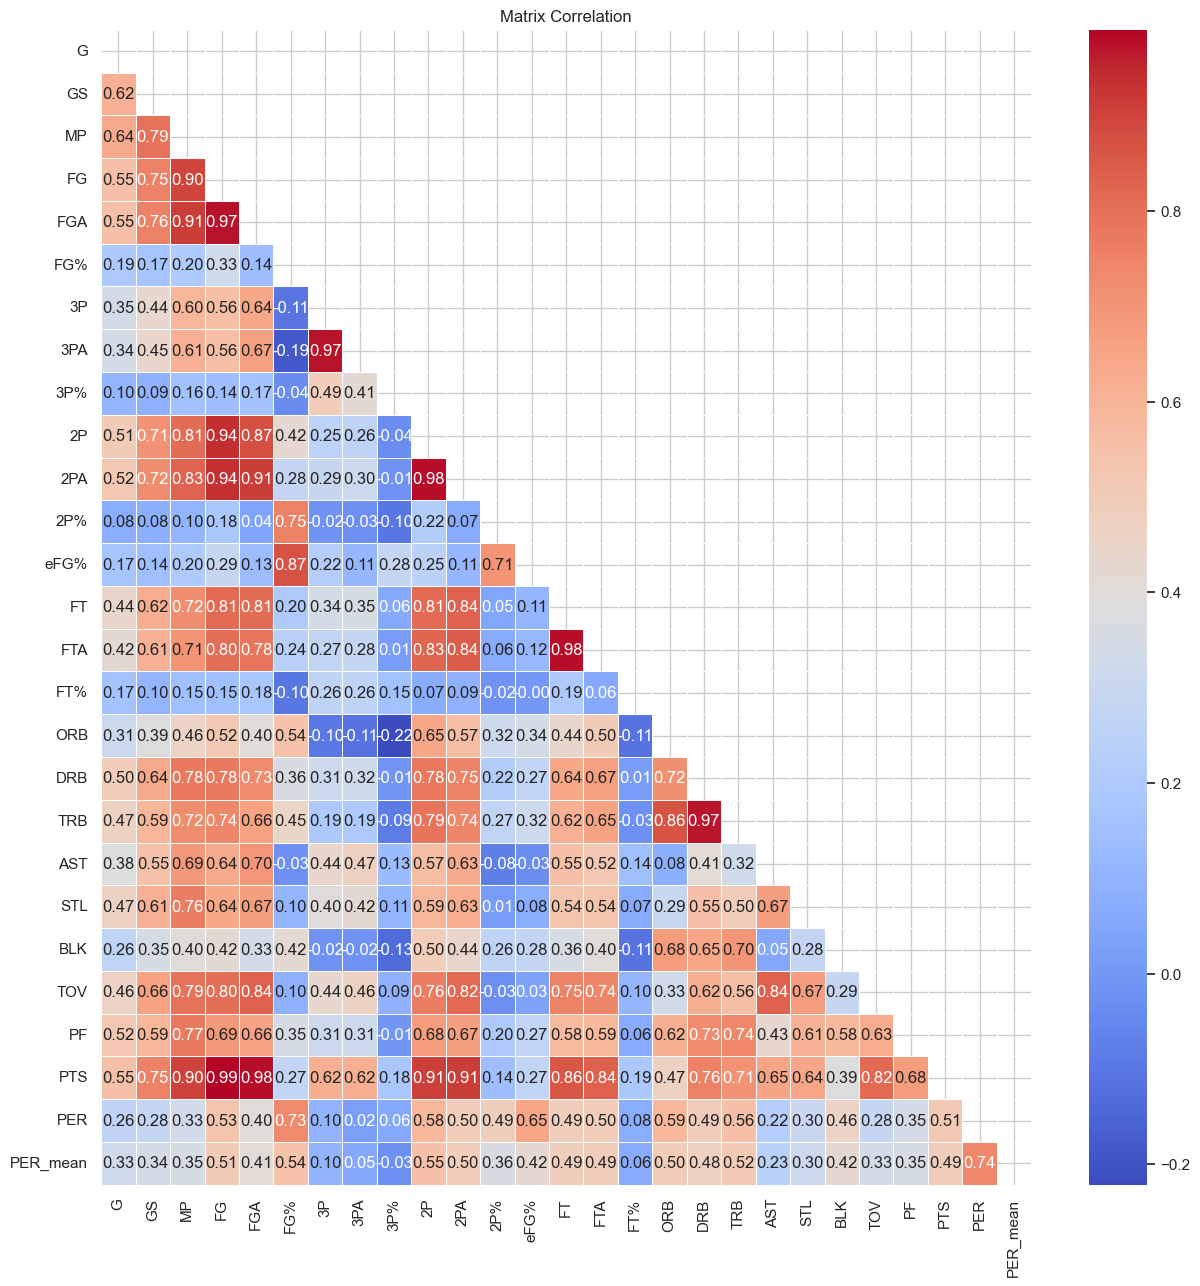

In [256]:
columns_of_interest = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
                        'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'PER_mean']

subset_df = rookies_df.dropna()[columns_of_interest]

# Calcolo della matrice di correlazione
correlation_matrix = subset_df.corr()

# Creazione di una matrice con la stessa forma di quella di correlazione ma con valori NaN
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creazione di un heatmap per visualizzare solo la metà superiore della matrice di correlazione
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title("Matrix Correlation")
plt.show()

**Strong Correlations with Points (PTS)**:
Field goals (FG), field goal attempts (FGA), minutes played (MP), and free throws (FT) show strong positive correlations with points scored. This suggests that players who have more playing time and shooting opportunities tend to score more.


**Other Notable Correlations**: Assists (AST), rebounds (TRB), and steals (STL) also correlate positively with points, indicating that players who contribute significantly in these areas often score higher points.

Now, we will select a few key statistics to explore and understand their correlations, both between each pair and in terms of the distribution of each individual variable. To achieve this, we will use a pairplot and a correlation matrix.

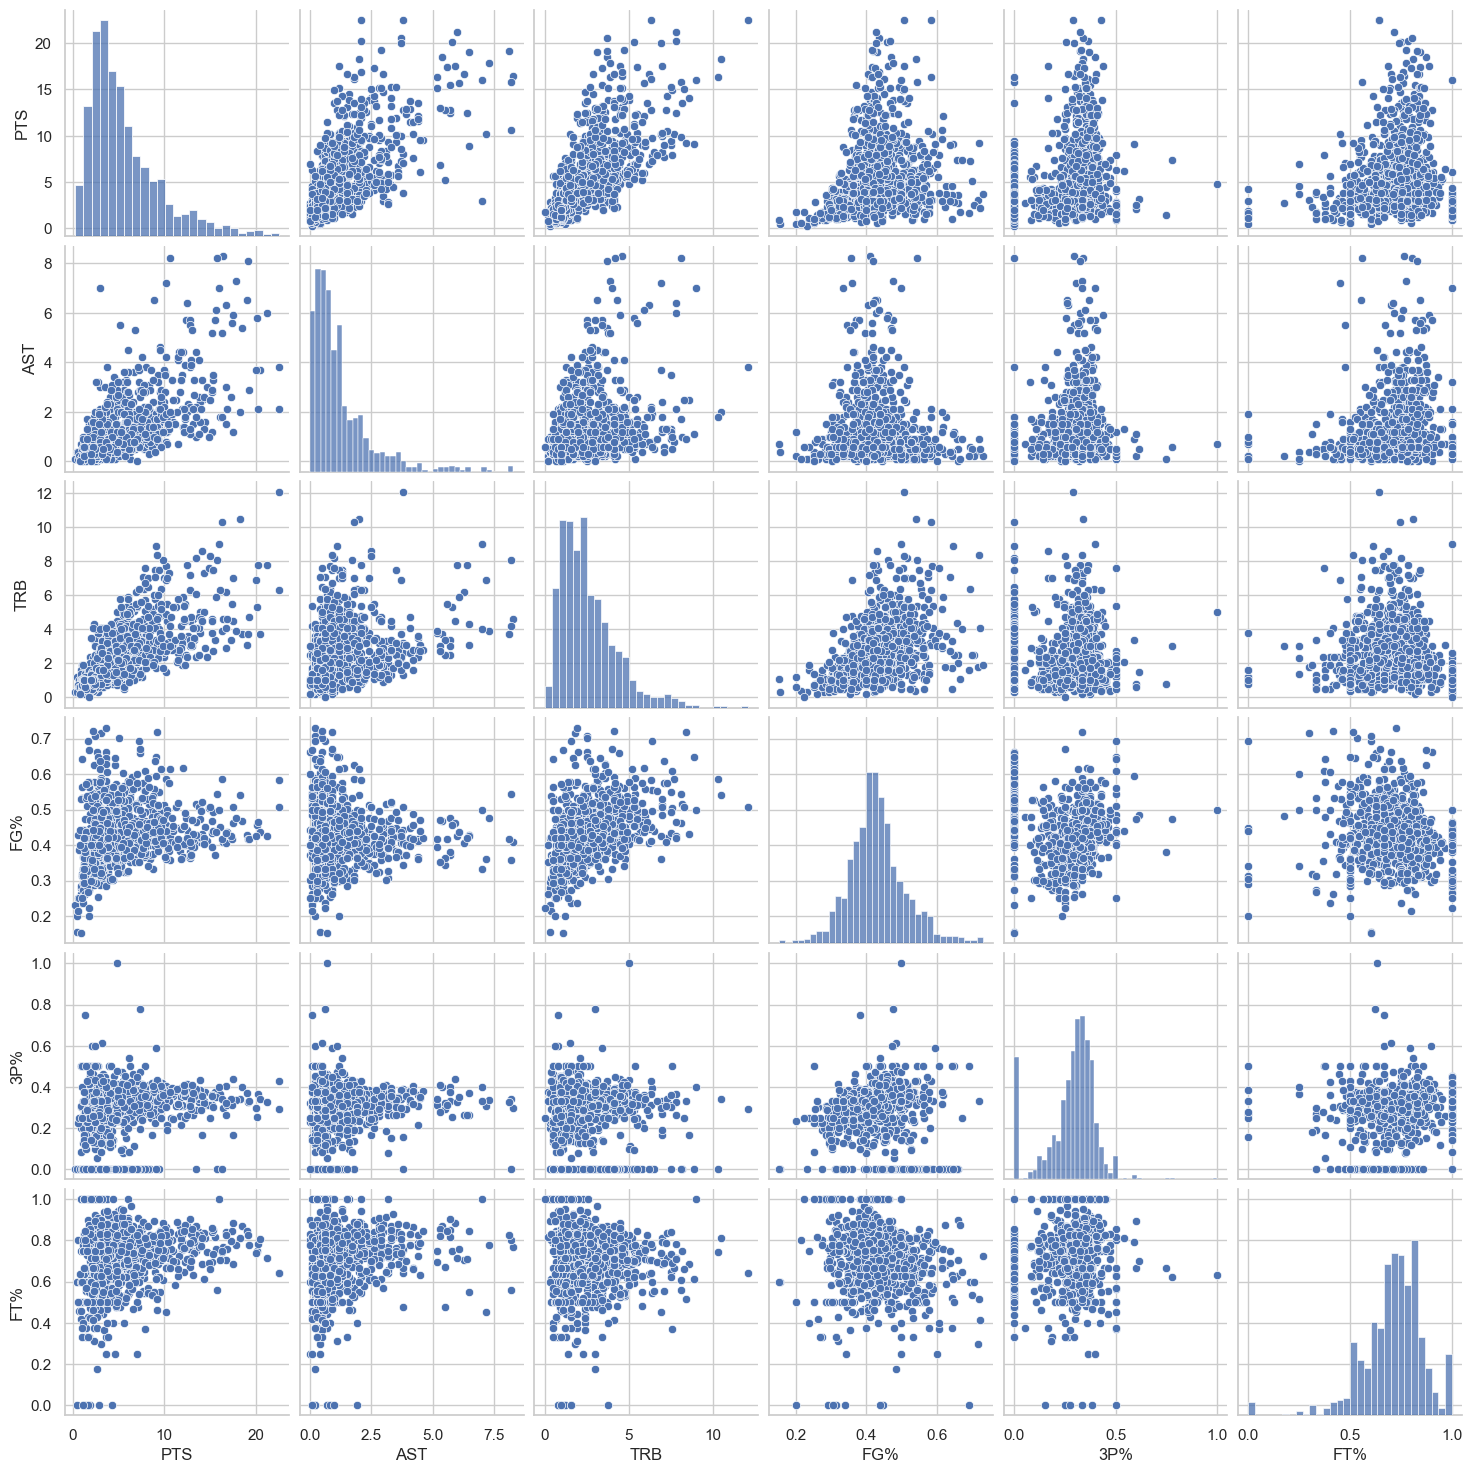

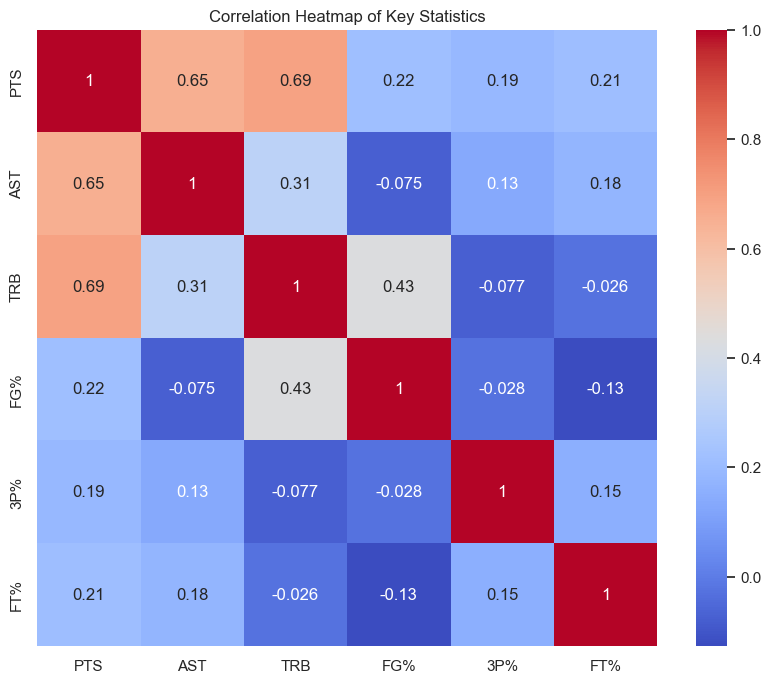

In [257]:
# Setting up the visualisation style
sns.set(style="whitegrid")

# Selecting a few key statistics for exploration
key_stats = ['PTS', 'AST', 'TRB', 'FG%', '3P%', 'FT%']

# Pairplot to visualize relationships between key stats
pairplot_data = rookies_df[key_stats]
sns.pairplot(pairplot_data)
plt.show()

# Correlation heatmap
corr = pairplot_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Key Statistics")
plt.show()

The pairplot reveals that:

- Points (PTS), assists (AST), and rebounds (TRB) tend to show positive correlations, suggesting that players who score more points also tend to contribute more assists and rebounds.
- 3P%, FT%, and FG% do not exhibit strong correlations with the other variables.

The correlation matrix between these variables confirms what is shown in the pairplot, highlighting the numerical values of the correlations

### 3.3 A glance for each year.

Let's compare rookie player's stats for every year, using boxplots.

In [258]:
rkdf = rookies_df.copy()
pldf = df_advanced.copy()

In [259]:
# Set a custom color palette for each year
palette = sns.color_palette("husl", n_colors=len(range(2010, 2024)))

Let's select the three most important variables (PTS, AST, TRB) and plot boxplots to illustrate their distribution across the range of years considered in our analysis. This will provide insights into how these key performance indicators have varied over time and help us identify trends or patterns in player performance.

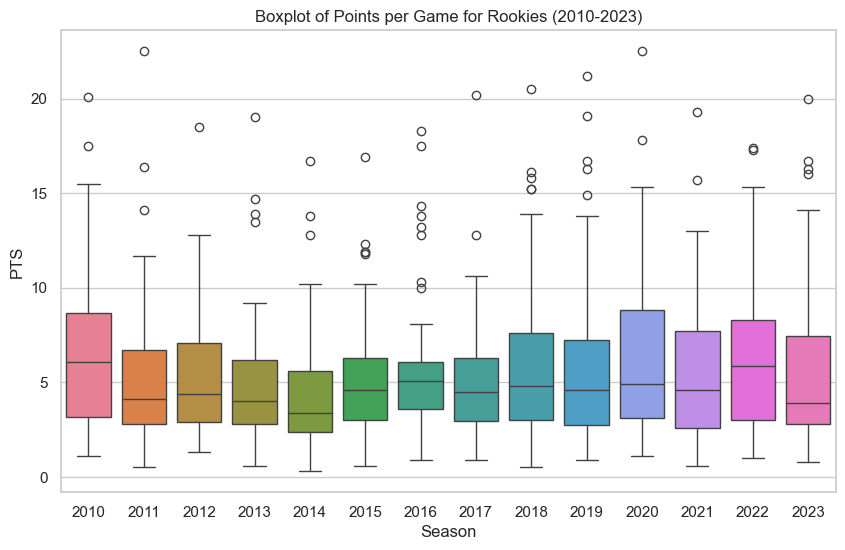

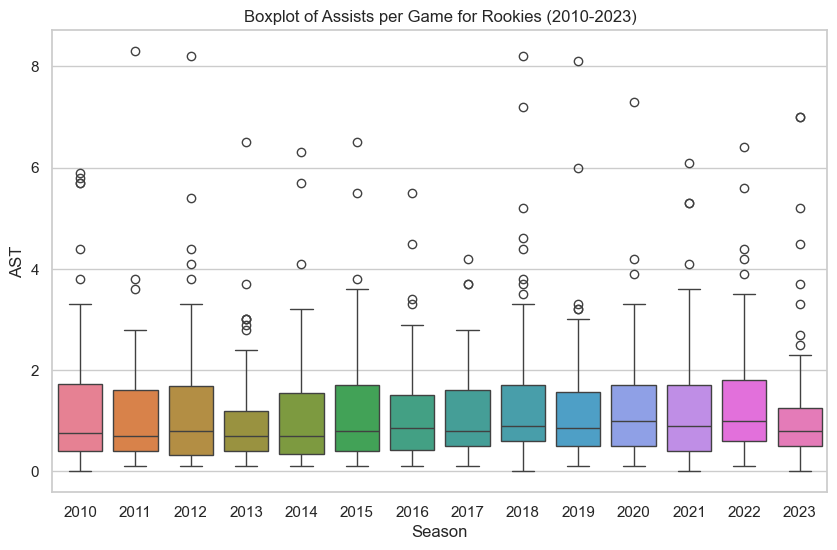

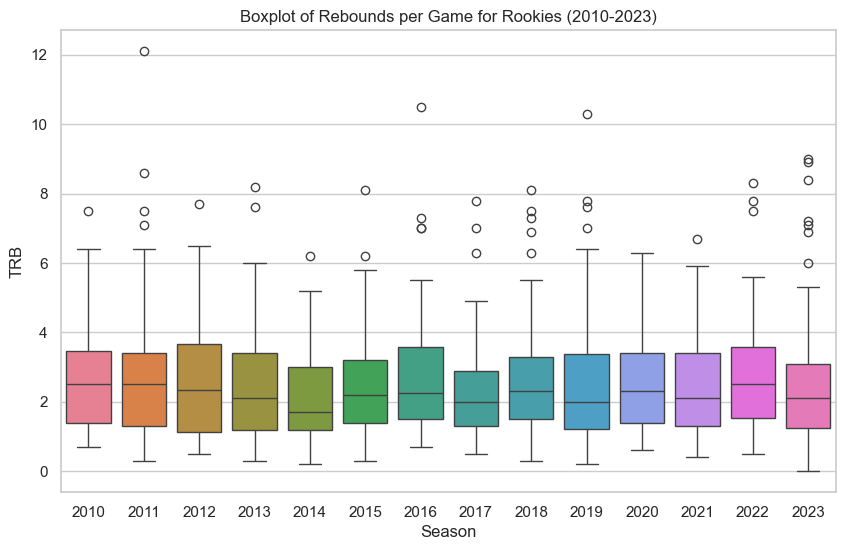

In [260]:
# Set a custom color palette for each year
palette = sns.color_palette("husl", n_colors=len(range(2010, 2024)))

# POINTS
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='PTS', data=rookies_df, palette=palette)
plt.title('Boxplot of Points per Game for Rookies (2010-2023)')
plt.show()

# ASSISTS
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='AST', data=rookies_df, palette=palette)
plt.title('Boxplot of Assists per Game for Rookies (2010-2023)')
plt.show()

# REBOUNDS
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='TRB', data=rookies_df, palette=palette)
plt.title('Boxplot of Rebounds per Game for Rookies (2010-2023)')
plt.show()


From the boxplots above, we can glean valuable statistics for comprehending the range of Points (PTS), Assists (AST), and Total Rebounds (TRB). Moreover, it becomes evident that outliers exert a pronounced influence compared to other players. Notably, these outliers exhibit a substantial prowess in the specified metrics.

Additionally, the absence of discernible trending patterns is noteworthy. There are no apparent trends indicating consistent improvements or declines across the years.

#### 3.3.4 Position analysis

Now let's compare rookies progress along the career years, making a distinction by position; making differences between the 3 variables (PTS, AST, TRB) as before.

In [261]:
# Assuming 'id' is the common column between the two dataframes
aux_df = pd.merge(merged_df, inv_rookies.rename(columns={'Season': 'Debut'}), on='ID')
# Calculate career year
aux_df['Career_Year'] = aux_df['Season'] - aux_df['Season'].min() + 1

# adjust the positions
aux_df['Pos'] = aux_df['Pos'].apply(standadize_role)

In [262]:
# it contains all the season stats 
# of the players that have been a rookie 
# between 2010 and 2023
aux_df.head(3)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean,Debut,Career_Year
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.5,2010,1
1,David Andersen,PF,30,TOT,40,0,9.3,1.4,3.0,0.463,0.2,0.6,0.348,1.2,2.5,0.490,0.496,0.4,0.6,0.636,0.5,1.6,2.1,0.3,0.1,0.2,0.6,1.0,3.4,2011,anderda03,10.9,0.3,0.032,11.5,2010,2
2,Antonio Anderson,SF,24,OKC,1,0,15.0,1.0,3.0,0.333,0.0,0.0,NaN,1.0,3.0,0.333,0.333,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2010,anderan02,-1.7,0.0,-0.104,-1.7,2010,1


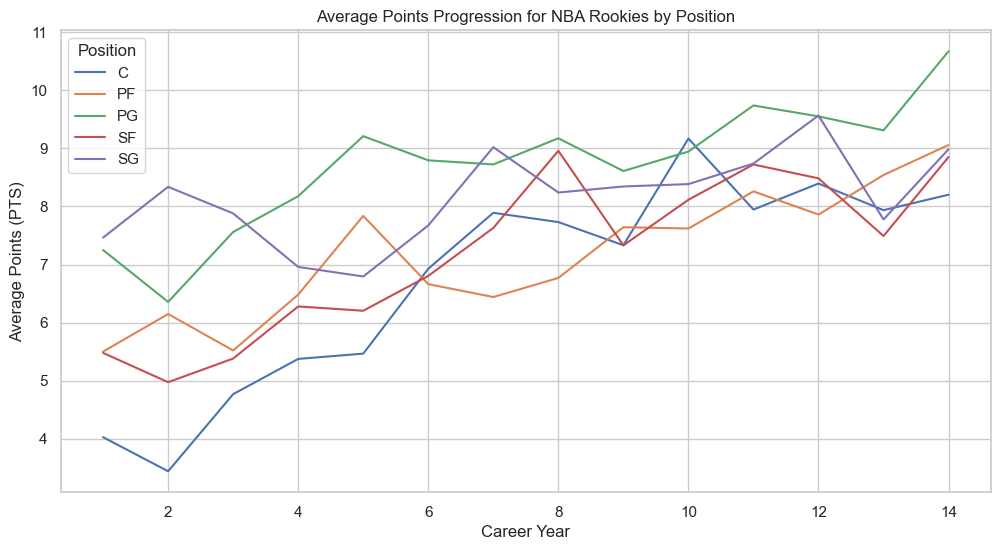

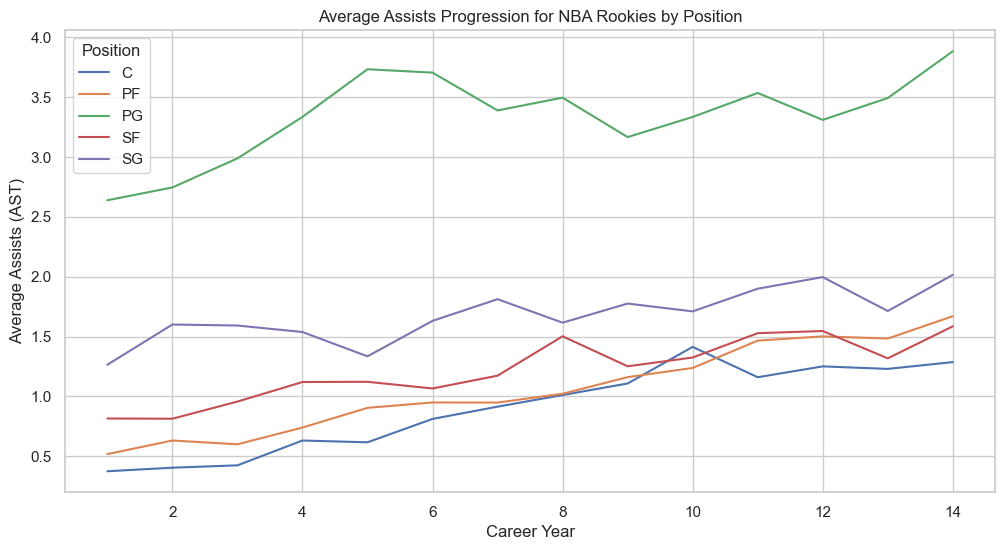

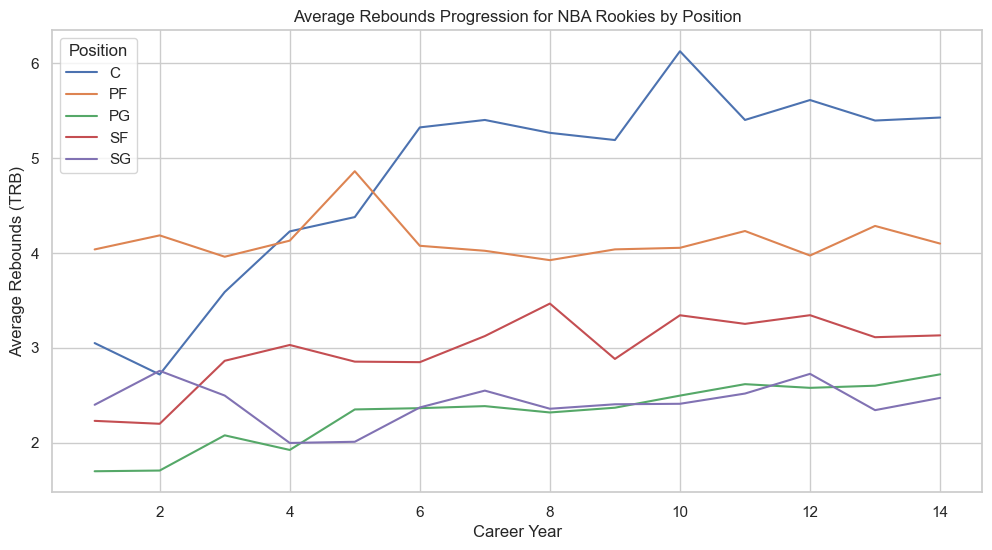

In [263]:
# Calculate average points for each career year and position
avg_points = aux_df.groupby(['Career_Year', 'Pos'])['PTS'].mean().reset_index()
avg_assists = aux_df.groupby(['Career_Year', 'Pos'])['AST'].mean().reset_index()
avg_rebounds = aux_df.groupby(['Career_Year', 'Pos'])['TRB'].mean().reset_index()

# Create a line plot for each position
plt.figure(figsize=(12, 6))
sns.lineplot(x='Career_Year', y='PTS', hue='Pos', data=avg_points)
plt.title('Average Points Progression for NBA Rookies by Position')
plt.xlabel('Career Year')
plt.ylabel('Average Points (PTS)')
plt.legend(title='Position')
plt.show()

# Create a line plot for each position
plt.figure(figsize=(12, 6))
sns.lineplot(x='Career_Year', y='AST', hue='Pos', data=avg_assists)
plt.title('Average Assists Progression for NBA Rookies by Position')
plt.xlabel('Career Year')
plt.ylabel('Average Assists (AST)')
plt.legend(title='Position')
plt.show()

# Create a line plot for each position
plt.figure(figsize=(12, 6))
sns.lineplot(x='Career_Year', y='TRB', hue='Pos', data=avg_rebounds)
plt.title('Average Rebounds Progression for NBA Rookies by Position')
plt.xlabel('Career Year')
plt.ylabel('Average Rebounds (TRB)')
plt.legend(title='Position')
plt.show()

These graphs reveal a trend throughout a rookie's entire career. As expected, the statistics of the three players analyzed consistently improve over the years. This progression is attributed to the initial years of a rookie's career, during which there is a natural focus on skill enhancement and development.

It is also notable that certain positions tend to have higher values in specific statistics compared to others. In particular:

- Shooting Guards (SG) and, more significantly, Point Guards (PG) demonstrate a consistently higher number of assists compared to other positions.
- Centers (C) and Power Forwards (PF) exhibit a higher number of Total Rebounds (TRB) than other positions, given their proximity to the basket, increasing their chances of securing successful rebounds.
- Points (PTS), on the other hand, do not show substantial differences across positions.

## 4. Regression

### 4.1 OLS Model

Let's move on using a linear regression model to predict PER_mean (of the entire career) using the other rookies' first year statistics.

Our final goal will be to predict PER_mean of the 2023 rookies.

In [264]:
# extracting 2023 rookies
rookies_2023_df = rookies_df[rookies_df['Season'] == 2023]
rookies_df = rookies_df[rookies_df['Season'] != 2023]

Let's gather information about the DataFrame we are using to perform regression.

In [265]:
# excluding NA values before doing the regression
rookies_df=rookies_df.dropna()
rookies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 789 entries, 0 to 1164
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    789 non-null    object 
 1   Pos       789 non-null    object 
 2   Age       789 non-null    int32  
 3   Tm        789 non-null    object 
 4   G         789 non-null    int32  
 5   GS        789 non-null    int32  
 6   MP        789 non-null    float64
 7   FG        789 non-null    float64
 8   FGA       789 non-null    float64
 9   FG%       789 non-null    float64
 10  3P        789 non-null    float64
 11  3PA       789 non-null    float64
 12  3P%       789 non-null    float64
 13  2P        789 non-null    float64
 14  2PA       789 non-null    float64
 15  2P%       789 non-null    float64
 16  eFG%      789 non-null    float64
 17  FT        789 non-null    float64
 18  FTA       789 non-null    float64
 19  FT%       789 non-null    float64
 20  ORB       789 non-null    float64
 2

Here we perform a 80-20 split of the players from 2010 till 2022:

1. We are going to use 80% of our players to train our OLS model, then check summary
2. We are going to use 20% of our players to test our OLS model, then use metrics like $R^2$ to evaluate performance
3. If our model is good we are going to use the rookie's stats from 2023 and try to predict their career PER_mean.

In [266]:
# Randomly select a portion of players for the training set, random_state for reproducibility
train_players, test_players = train_test_split(rookies_df, test_size=0.2, random_state=42)

# Extract features (X) and target variable (y) using the specified indexes
# Train
train_x=train_players.drop(columns = ["Player","Pos","Tm","Season","ID","WS","PER_mean"])  # Features
train_y = train_players['PER_mean']  # Target variable

# Test
test_x = test_players.drop(columns = ["Player","Pos","Tm","Season","ID","WS","PER_mean"])  # Features
test_y = test_players['PER_mean']  # Target variable

# Print shape 
print("Shapes:")
print("train_x:", train_x.shape)
print("train_y:", train_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

Shapes:
train_x: (631, 28)
train_y: (631,)
test_x: (158, 28)
test_y: (158,)


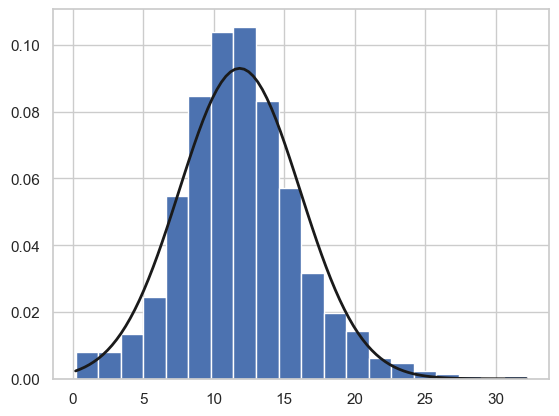

In [267]:
Y=rookies_df["PER_mean"] # predicted variable
Y.hist(bins=20, density = True)

mu, std = Y.mean(), Y.std()

# Create an array of x values for the Gaussian curve
x = np.linspace(Y.min(), Y.max(), 100)
p = norm.pdf(x, mu, std)

# Draw the Gaussian curve
plt.plot(x, p, 'k', linewidth=2)
plt.show()


The distribution of PER_mean for all the past players from 2010 to 2022 looks like a Gaussian distribution, so we can use ordinary least squares (OLS). This will be nice because while OLS is not flexible, it’s highly interpretable.

We will explore more sophisticated methods later in the discussion.

In [268]:
train_x=sm.add_constant(train_x)
train_x=train_x.reset_index(drop=True)
train_y=train_y.reset_index(drop=True)

In [269]:
len(train_y),len(train_x)

(631, 631)

In [270]:
# Train our model
reg=sm.OLS(train_y,train_x).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     32.28
Date:                Wed, 27 Dec 2023   Prob (F-statistic):          6.99e-101
Time:                        18:38:12   Log-Likelihood:                -1540.2
No. Observations:                 631   AIC:                             3138.
Df Residuals:                     602   BIC:                             3267.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2870      2.326      4.422      0.0

Some considerations:

1. Model Statistics:
- **R-squared**: 0.600 - This is the proportion of the variance in the dependent variable (PER_mean) that is predictable from the independent variables. In this case, the model explains 60.0% of the variability in PER_mean.
- -**Adj. R-squared** : 0.582 - It's similar to R-squared but penalizes the inclusion of irrelevant variables. It's slightly lower than R-squared here.
2. Coefficients:
- Each coefficient represents the change in the dependent variable (PER_mean) for a one-unit change in the corresponding independent variable, holding other variables constant.
- Age: For example this coefficient (-0.23), suggests that for every one-year increase in age, PER_mean decreases by approximately 0.28.
- 3P: For example this coefficient (4.54), suggests that for every additional three-point field goal (3P) made in a rookie season, the model predicts an increase of approximately 4.54 units in PER_mean.
3. Significance of Coefficients:
- The P>|t| values indicate the probability that each coefficient is not equal to zero. Smaller p-values suggest that the corresponding variable is significant.
- For example, Age has a very small p-value (0.056), indicating that it is likely a significant predictor of PER_mean.


Text(0, 0.5, 'Predicted PER')

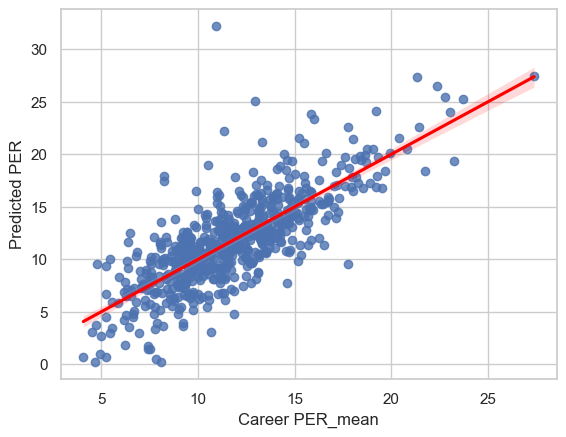

In [271]:
# plot of predicted PER against actual PER.
sns.regplot(x=reg.predict(train_x), y=train_y,line_kws={'color': 'red'})
plt.xlabel('Career PER_mean')
plt.ylabel('Predicted PER')

Above we have a quick plot of predicted PER against real career PER_mean. The red line isn't the best-fit line, it’s the bisector line, plotted to help visualize where the model fails.

We notice that our model predicts well the average players, but underestimates the elite rookies and overestimates the worst.

### 4.2 Evaluation of the model

Let's evaluate our model by checking the test, initially using R-squared.

In [272]:
# Add a constant term to the test features
test_x = sm.add_constant(test_x)
test_x = test_x.reset_index(drop=True)

# Predict using the fitted OLS model
predictions = reg.predict(test_x)

In [273]:
# Evaluate the model on the test set
r_squared = r2_score(test_y, predictions)

print(f'R-squared: {r_squared}')

R-squared: 0.5414086546380659


A R-squared value of 0.541 indicates that the model explains approximately 54% of the variance in the target variable on the test set. This is a reasonably good R-squared value, suggesting that the model captures a significant portion of the variability in the PER_mean variable.

Let's try with other different accuracy measures:

1. Mean Squared Error: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
2. Mean Absolute Error: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
3. Mean Absolute Percentage Error: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \cdot 100$


In [274]:
def mean_squared_error(actual, predicted):
    """
    Calculates the Mean Squared Error (MSE).

    Parameters:
    - actual: Array of observed values.
    - predicted: Array of predicted values.

    Returns:
    - MSE: The Mean Squared Error.
    """
    n = len(actual)
    mse = sum((actual[i] - predicted[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(actual, predicted):
    """
    Calculates the Mean Absolute Error (MAE).

    Parameters:
    - actual: Array of observed values.
    - predicted: Array of predicted values.

    Returns:
    - MAE: The Mean Absolute Error.
    """
    n = len(actual)
    mae = sum(abs(actual[i] - predicted[i]) for i in range(n)) / n
    return mae

def mean_absolute_percentage_error(actual, predicted):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).

    Parameters:
    - actual: Array of observed values.
    - predicted: Array of predicted values.

    Returns:
    - MAPE: The Mean Absolute Percentage Error.
    """
    n = len(actual)
    mape = (1/n) * sum(abs((actual[i] - predicted[i]) / actual[i]) * 100 for i in range(n))
    return mape


In [275]:
# Mean Squared Error (MSE)
mse = round(mean_squared_error(np.array(test_y), np.array(predictions)), 2)
print(f"Mean Squared Error (MSE): {mse}")

# Mean Absolute Error (MAE)
mae = round(mean_absolute_error(np.array(test_y), np.array(predictions)), 2)
print(f"Mean Absolute Error (MAE): {mae}")

# Mean Absolute Percentage Error (MAPE)
mape = round(mean_absolute_percentage_error(np.array(test_y), np.array(predictions)), 2)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Squared Error (MSE): 6.72
Mean Absolute Error (MAE): 1.9
Mean Absolute Percentage Error (MAPE): 20.94%


In particular:

- A lower MSE indicates a better model fit. In our context, the value of 6.72 suggests a moderate level of dispersion.
- A lower MAE implies better accuracy. The value of 1.9 indicates, on average, a difference of approximately 1.9 units between predicted and observed values.
- A lower MAPE indicates better accuracy in percentage terms. The value of 20.94% suggests that, on average, the predictions deviate by approximately 20.94% from the observed values.

So, given its simplicity, our regression model does a remarkably good job, but, as we have seen in the paragraph before, has some defects that we will try to adjust.

### 4.3 Prediction for 2023 rookies

Let's finally make the prediction for 2023 rookies.

In [277]:
rookies_df_2023 = rookies_2023_df.drop(columns = ["Player","Pos","Tm","Season","ID","WS","PER_mean"])
rookies_df_2023 = sm.add_constant(rookies_df_2023)
rookies_df_2023 = rookies_df_2023.reset_index(drop=True)
rookies_df_2023.head()

,const,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,WS/48
0,1.0,22,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,1.4,2.7,0.532,0.532,0.9,1.2,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,9.5,0.053
1,1.0,20,31,0,7.3,1.4,3.5,0.394,1.0,2.7,0.381,0.4,0.8,0.440,0.541,0.1,0.2,0.667,0.0,1.3,1.3,0.4,0.2,0.1,0.4,0.5,3.9,11.3,0.029
2,1.0,20,72,72,33.8,6.7,15.6,0.427,1.2,4.0,0.298,5.5,11.6,0.471,0.465,5.5,7.4,0.738,1.2,5.7,6.9,3.7,0.8,0.5,2.8,2.2,20.0,14.9,0.047
3,1.0,19,28,0,14.6,1.6,3.1,0.535,0.0,0.1,0.000,1.6,2.9,0.561,0.535,0.6,0.9,0.720,1.6,2.0,3.6,0.9,0.4,0.7,0.5,2.0,3.9,12.4,0.082
4,1.0,22,52,11,13.5,1.8,4.7,0.395,0.9,2.7,0.331,0.9,1.9,0.485,0.492,0.5,0.7,0.730,0.7,1.5,2.2,0.7,0.4,0.1,0.9,1.4,5.1,8.2,0.027


In [278]:
rookies_df_2023.shape

(79, 29)

In [279]:
# Predict using the fitted OLS model
predictions = reg.predict(rookies_df_2023)
rookies_2023_df['PER_pred'] = predictions.values.round(2)
rookies_2023_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean,PER_pred
1165,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,1.4,2.7,0.532,0.532,0.9,1.2,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,2023,agbajoc01,9.5,1.3,0.053,9.5,10.96
1166,Patrick Baldwin Jr.,SF,20,GSW,31,0,7.3,1.4,3.5,0.394,1.0,2.7,0.381,0.4,0.8,0.440,0.541,0.1,0.2,0.667,0.0,1.3,1.3,0.4,0.2,0.1,0.4,0.5,3.9,2023,baldwpa01,11.3,0.1,0.029,11.3,11.07
1167,Paolo Banchero,PF,20,ORL,72,72,33.8,6.7,15.6,0.427,1.2,4.0,0.298,5.5,11.6,0.471,0.465,5.5,7.4,0.738,1.2,5.7,6.9,3.7,0.8,0.5,2.8,2.2,20.0,2023,banchpa01,14.9,2.4,0.047,14.9,19.30
1168,Dominick Barlow,PF,19,SAS,28,0,14.6,1.6,3.1,0.535,0.0,0.1,0.000,1.6,2.9,0.561,0.535,0.6,0.9,0.720,1.6,2.0,3.6,0.9,0.4,0.7,0.5,2.0,3.9,2023,barlodo01,12.4,0.7,0.082,12.4,13.87
1169,MarJon Beauchamp,SF,22,MIL,52,11,13.5,1.8,4.7,0.395,0.9,2.7,0.331,0.9,1.9,0.485,0.492,0.5,0.7,0.730,0.7,1.5,2.2,0.7,0.4,0.1,0.9,1.4,5.1,2023,beaucma01,8.2,0.4,0.027,8.2,9.73


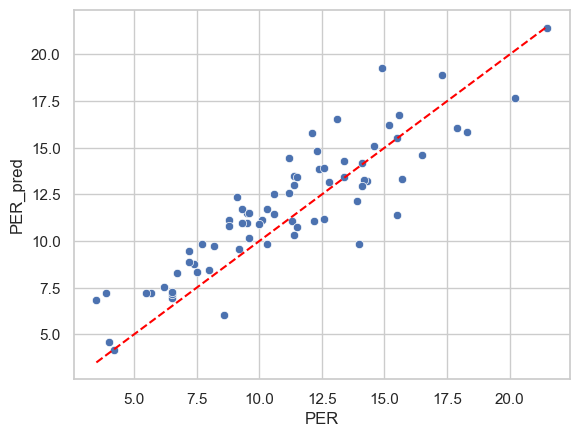

In [280]:
sns.scatterplot(x=rookies_2023_df["PER"],y=rookies_2023_df["PER_pred"])
plt.plot([rookies_2023_df["PER"].min(), rookies_2023_df["PER"].max()],
        [rookies_2023_df["PER"].min(), rookies_2023_df["PER"].max()],
        linestyle='--', color='red', label='Bisector')

The graph above shows how the model predicts who will stay on the same level and who is gonna increase or decrease his PER during the rest of his career.
Most of them, according to our model, will increase their PER.

## 5. PCA

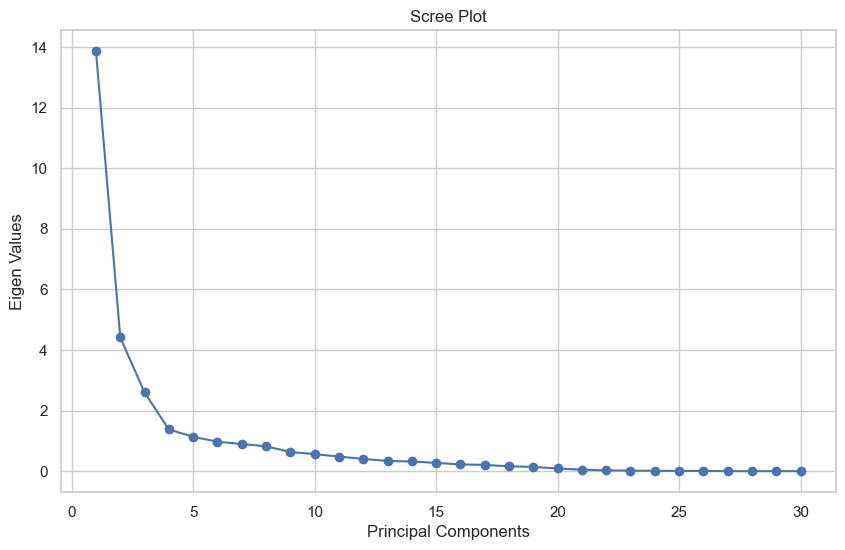

In [281]:
numeric_columns = rookies_df.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns[numeric_columns != 'PER_mean']
rookies_data = rookies_df[numeric_columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(rookies_data)

pca = PCA()
pca_result = pca.fit_transform(scaled_data)

eigenvalues = pca.explained_variance_

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigen Values')
plt.grid(True)
plt.show()

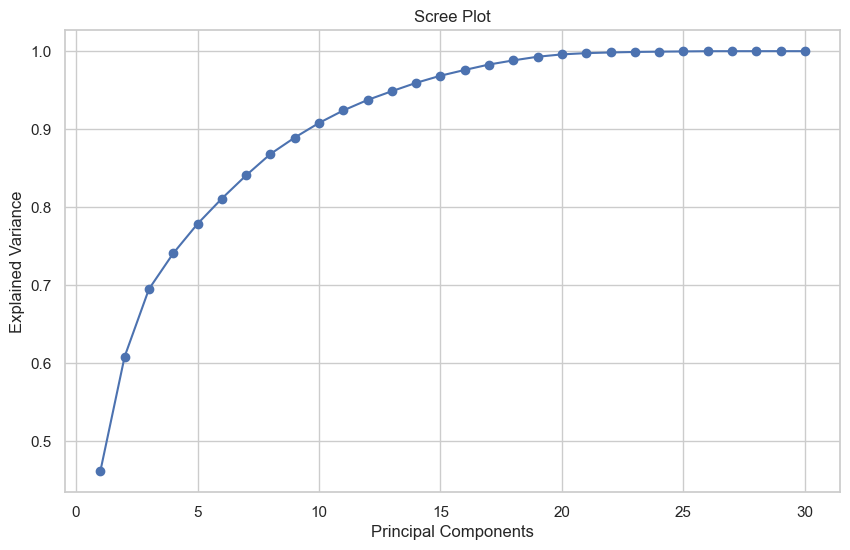

In [282]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()


In [283]:
numeric_columns = rookies_df.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns[numeric_columns != 'PER_mean']  # Escludi la variabile dipendente
rookies_data = rookies_df[numeric_columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(rookies_data)

num_components = 4

pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(scaled_data)

pca_columns = [f'PC{i+1}' for i in range(num_components)]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

result_df = pd.concat([rookies_df[['PER_mean']], pca_df], axis=1)

result_df.head(10)


,PER_mean,PC1,PC2,PC3,PC4
0,11.50,-0.204827,0.945757,0.160886,2.216555
3,13.95,-2.073476,1.712344,0.576321,2.137155
4,13.91,1.781645,0.037683,-1.735985,1.562040
6,13.40,4.000334,-0.303798,0.029391,1.027271
7,12.63,-3.510247,-0.868657,1.633510,1.351331
8,12.08,5.672028,-1.637262,-0.272479,3.595539
9,13.12,-0.950608,3.011658,1.564077,1.670762
10,9.15,10.469783,-3.443557,-2.037276,2.261700
11,14.75,-0.229170,1.295599,-0.204078,1.332429
12,11.37,3.127589,0.958199,1.479073,1.903479


In [284]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'PER_mean' is your target variable
target_variable = 'PER_mean'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, rookies_df[target_variable], test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Now you can use the trained model to make predictions on new data
# For example, if you have a new set of principal components called 'new_data'
# new_predictions = model.predict(new_data)


Mean Squared Error: 7.773454097980431
R-squared: 0.4698114470285718


## 5. Clustering for a better regression model

The linear regression model does a good job given its simplicity, but it also leaves a lot of
variance unexplained. This because one linear regression model is unlikely to successfully
predict all kind of different players.

A way to solve this problem is grouping them in clusters and examine how groupings impact ability to predict career performance. This is the strategy we will employ in the upcoming paragraphs.

### 5.1 K-Means Algorithm

In [285]:
# We merge back together the rookies_df and the rookies_2023_df into cluster_df
cluster_df = pd.concat([rookies_df, rookies_2023_df.drop(["PER_pred"],axis=1)], ignore_index=True)
cluster_df.head(5)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.50
1,Rodrigue Beaubois,PG,21,DAL,56,16,12.5,2.8,5.3,0.518,0.8,2.0,0.409,2.0,3.4,0.582,0.594,0.8,0.9,0.808,0.2,1.2,1.4,1.3,0.5,0.2,1.0,1.5,7.1,2010,beaubro01,18.5,2.0,0.134,13.95
2,DeJuan Blair,PF,20,SAS,82,23,18.2,3.4,6.0,0.556,0.0,0.0,0.000,3.4,6.0,0.558,0.556,1.1,2.0,0.547,2.4,4.0,6.4,0.8,0.6,0.5,1.4,2.7,7.8,2010,blairde01,17.7,4.6,0.147,13.91
3,Derrick Brown,SF,22,CHA,57,0,9.4,1.2,2.6,0.463,0.0,0.1,0.286,1.2,2.5,0.471,0.469,0.8,1.3,0.667,0.5,0.8,1.4,0.3,0.4,0.2,0.3,0.9,3.3,2010,brownde04,12.6,1.3,0.114,13.40
4,Chase Budinger,SF,21,HOU,74,4,20.1,3.4,7.6,0.441,1.2,3.4,0.369,2.1,4.3,0.497,0.522,0.9,1.2,0.770,0.5,2.5,3.0,1.2,0.5,0.1,0.6,1.1,8.9,2010,budinch01,14.1,3.1,0.100,12.63


We will use the K-means algorithm to divide the players in clusters depending from the values of their basic statistics: Points per game (PTS), Assists per game (AST) and Total rebounds per game (TRB).

In the initialization step, you choose the number of clusters (k) and initialize centroids for each cluster. The algorithm then iteratively assigns data points to the cluster with the nearest centroid and updates the centroids based on the mean of the assigned points. This process continues until convergence, where cluster assignments stabilize, and centroids no longer change significantly. The final result is a set of k clusters, each containing data points with similar features.

Before moving on we will use the scree plot to understand the ideal number of clusters to choose.

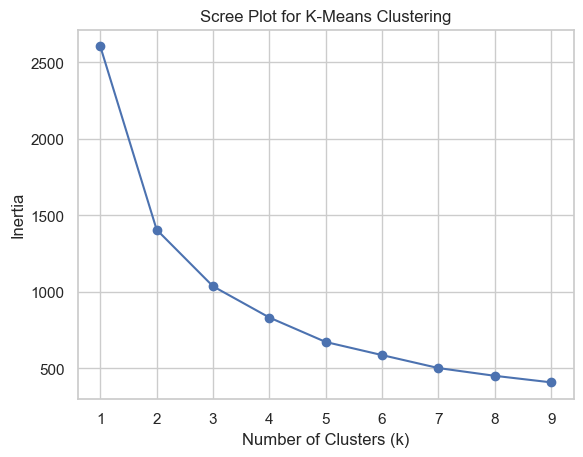

In [286]:
features = cluster_df[['TRB', 'AST', 'PTS']]
  
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

k_values = range(1, 10)  # You can adjust the range based on your data and requirements

# Calculate the inertia for each k
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the scree plot
plt.plot(k_values, inertia_values, marker='o')
plt.title('Scree Plot for K-Means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


We can employ the elbow method to determine the optimal number of clusters. In our case, based on the scree plot, we have chosen $k=3$ clusters. 

This decision is grounded in the observation that 3 is the elbow point of the plot. The elbow point represents the juncture where the Inertia (within-cluster sum of squares) starts to decrease more gradually, signifying that adding more clusters does not significantly enhance the model fit.

Let's apply the K-means algorithm to group the players into 3 clusters.

In [287]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(features_scaled)+1

Now let's give a graphical representation of the clusters.

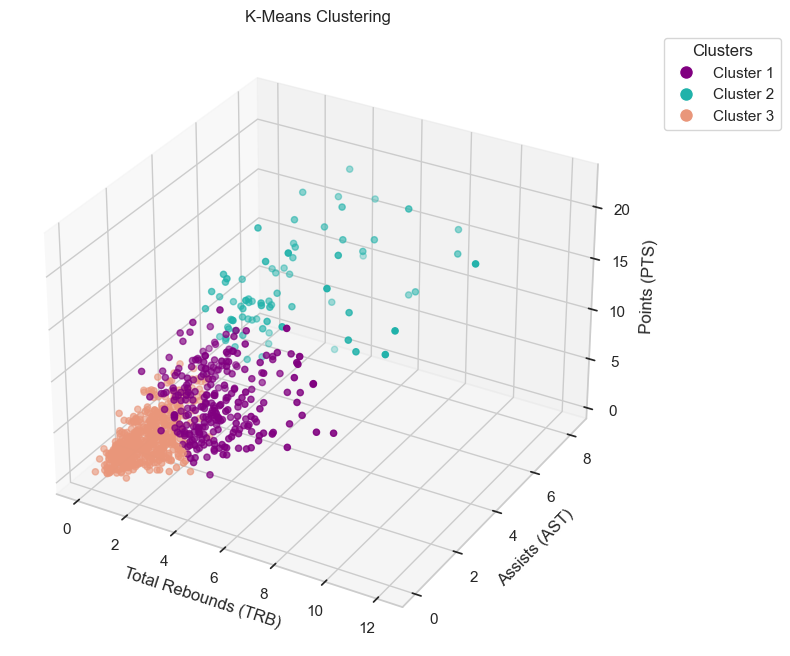

In [288]:
colors = {1: 'Purple', 2: 'LightSeaGreen', 3: 'DarkSalmon'}

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(cluster_df["TRB"], cluster_df["AST"], cluster_df["PTS"], c=cluster_df["cluster"].map(colors))

ax.set_title("K-Means Clustering")
ax.set_xlabel("Total Rebounds (TRB)")
ax.set_ylabel("Assists (AST)")
ax.set_zlabel("Points (PTS)")


# Create custom legend entries
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {cluster}') for cluster, color in colors.items()]

# Adding a legend
ax.legend(handles=legend_elements, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### 5.2 Analysis of the clusters

Now the players are grouped by their stats based on their skills, as we can see from the analysis below.

In [289]:
cluster_1=cluster_df[cluster_df["cluster"]==1]
np.round(cluster_1[["PTS","AST","TRB"]].describe().loc[['mean', 'min','max']],2)


,PTS,AST,TRB
mean,8.11,1.38,4.01
min,2.30,0.00,1.50
max,17.50,3.70,8.90


In [290]:
cluster_2=cluster_df[cluster_df["cluster"]==2]
np.round(cluster_2[["PTS","AST","TRB"]].describe().loc[['mean', 'min','max']],2)

,PTS,AST,TRB
mean,13.79,4.39,4.39
min,3.00,1.80,1.60
max,22.50,8.30,12.10


In [291]:
cluster_3=cluster_df[cluster_df["cluster"]==3]
np.round(cluster_3[["PTS","AST","TRB"]].describe().loc[['mean', 'min','max']],2)

,PTS,AST,TRB
mean,3.54,0.86,1.58
min,0.50,0.00,0.00
max,8.00,3.80,3.60


In [292]:
# number of players in each cluster
len(cluster_1),len(cluster_2),len(cluster_3)

(263, 79, 526)

From the tables above we can notice that:

- **Cluster 1** groups all the rookies who had an average performance during their first season.
- **Cluster 2** groups all the rookies who had a very good performance during their first season.
- **Cluster 3** groups all the rookies who had a very bad performance during their first season.

## 6. Regression model on the clusters

Now it is possible to apply regression again to each of the three clusters (Average, Top, Worse) to obtain a more accurate prediction.

### 6.1 "Average" Rookies

In [293]:
A_rook=cluster_1[cluster_1['Season']!=2023]
A_rook=A_rook.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
A_rook=sm.add_constant(A_rook)
A_rook=A_rook.reset_index(drop=True)

Y_a=cluster_1.loc[cluster_1['Season'] != 2023, 'PER_mean']
Y_a=Y_a.reset_index(drop=True)

In [294]:
reg_a=sm.OLS(Y_a,A_rook).fit()
print(reg_a.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     9.235
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           7.76e-24
Time:                        18:38:16   Log-Likelihood:                -565.49
No. Observations:                 240   AIC:                             1189.
Df Residuals:                     211   BIC:                             1290.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7933      7.956      2.111      0.0

<Axes: ylabel='PER_mean'>

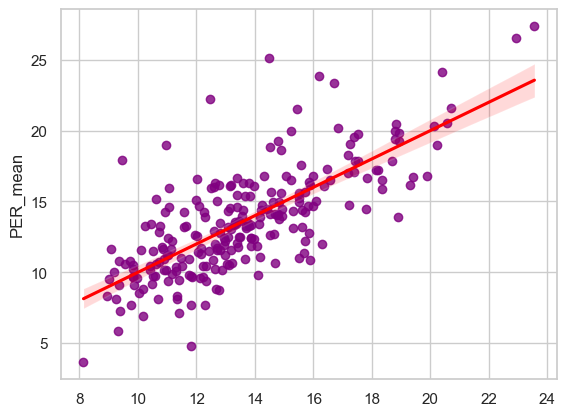

In [295]:
sns.regplot(x=reg_a.predict(A_rook), y=Y_a,line_kws={'color': 'red'},scatter_kws={"color":'purple'})

### 6.2 "Top" Rookies

In [296]:
T_rook=cluster_2[cluster_2['Season']!=2023]
T_rook=T_rook.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
T_rook=sm.add_constant(T_rook)
T_rook=T_rook.reset_index(drop=True)

Y_t=cluster_2.loc[cluster_2['Season'] != 2023, 'PER_mean']
Y_t=Y_t.reset_index(drop=True)

In [297]:
reg_t=sm.OLS(Y_t,T_rook).fit()
print(reg_t.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     7.155
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           5.31e-09
Time:                        18:38:17   Log-Likelihood:                -145.24
No. Observations:                  73   AIC:                             348.5
Df Residuals:                      44   BIC:                             414.9
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.3615     16.823      1.745      0.0

<Axes: ylabel='PER_mean'>

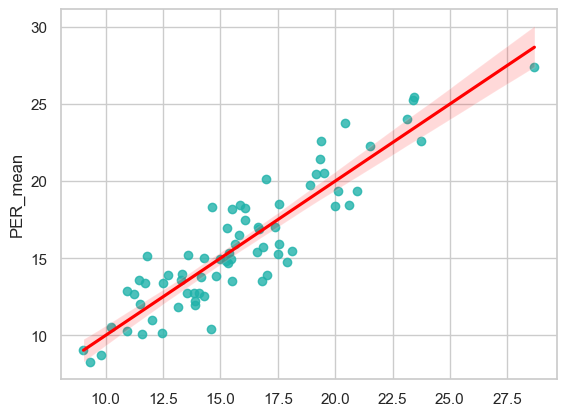

In [298]:
sns.regplot(x=reg_t.predict(T_rook), y=Y_t,line_kws={'color': 'red'},scatter_kws={"color":'LightSeaGreen'})

### 6.3 "Worse" Rookies

In [299]:
W_rook=cluster_3[cluster_3['Season']!=2023]
W_rook=W_rook.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
W_rook=sm.add_constant(W_rook)
W_rook=W_rook.reset_index(drop=True)

Y_w=cluster_3.loc[cluster_3['Season'] != 2023, 'PER_mean']
Y_w=Y_w.reset_index(drop=True)

In [300]:
reg_w=sm.OLS(Y_w,W_rook).fit()
print(reg_w.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     13.75
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           1.95e-44
Time:                        18:38:17   Log-Likelihood:                -1158.7
No. Observations:                 476   AIC:                             2375.
Df Residuals:                     447   BIC:                             2496.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8389      2.633      2.597      0.0

<Axes: ylabel='PER_mean'>

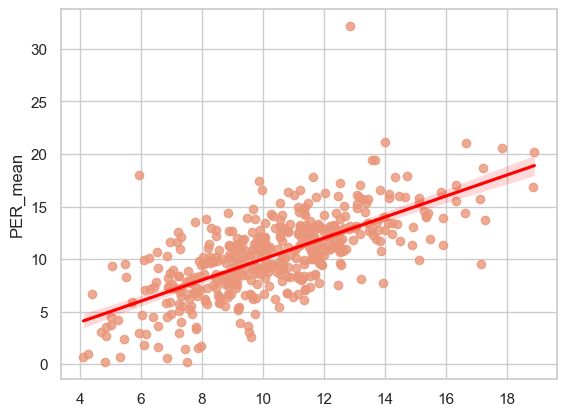

In [301]:
sns.regplot(x=reg_w.predict(W_rook), y=Y_w,line_kws={'color': 'red'},scatter_kws={"color":"DarkSalmon"})

## 7. New Predictions

#### CLUSTER 1

In [302]:
rookies_cluster1=cluster_1[cluster_1['Season']==2023]
rookies_cluster1=rookies_cluster1.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
rookies_cluster1 = sm.add_constant(rookies_cluster1)
rookies_cluster1 = rookies_cluster1.reset_index(drop=True)

In [303]:
rkcl1=rookies_2023_df.merge(cluster_1.loc[cluster_1['Season'] == 2023, ['ID']], on='ID')

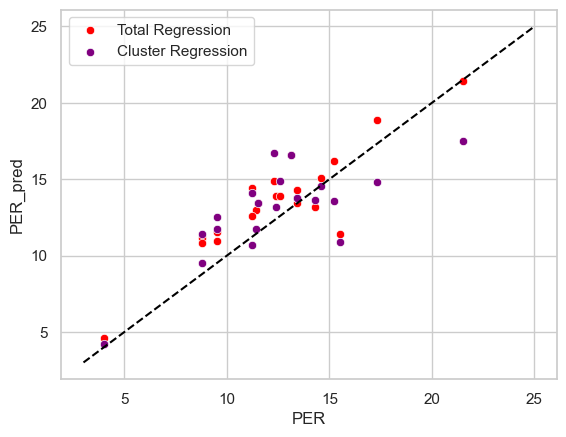

In [304]:
sns.scatterplot(x=rkcl1["PER"], y=rkcl1["PER_pred"], label="Total Regression",color='red')
sns.scatterplot(x=rookies_cluster1["PER"],y=reg_w.predict(rookies_cluster1),label="Cluster Regression",color="Purple")

plt.plot([3, 25],[3, 25],linestyle='--', color='black', label='Bisector')
plt.show()

#### CLUSTER 2

In [305]:
rookies_cluster2=cluster_2[cluster_2['Season']==2023]
rookies_cluster2=rookies_cluster2.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
rookies_cluster2 = sm.add_constant(rookies_cluster2)
rookies_cluster2 = rookies_cluster2.reset_index(drop=True)

In [306]:
rkcl2=rookies_2023_df.merge(cluster_2.loc[cluster_2['Season'] == 2023, ['ID']], on='ID')

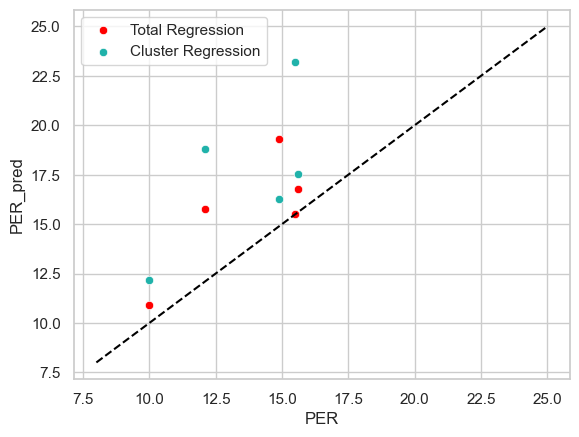

In [307]:
sns.scatterplot(x=rkcl2["PER"], y=rkcl2["PER_pred"], label="Total Regression",color='red')
sns.scatterplot(x=rookies_cluster2["PER"],y=reg_t.predict(rookies_cluster2),label="Cluster Regression",color='LightSeaGreen')

plt.plot([8, 25],[8, 25],linestyle='--', color='black', label='Bisector')
plt.show()

#### CLUSTER 3

In [308]:
rookies_cluster3 = cluster_3[cluster_3['Season']==2023]
rookies_cluster3 = rookies_cluster3.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
rookies_cluster3 = sm.add_constant(rookies_cluster3)
rookies_cluster3 = rookies_cluster3.reset_index(drop=True)

In [309]:
rkcl3=rookies_2023_df.merge(cluster_3.loc[cluster_3['Season'] == 2023, ['ID']], on='ID')

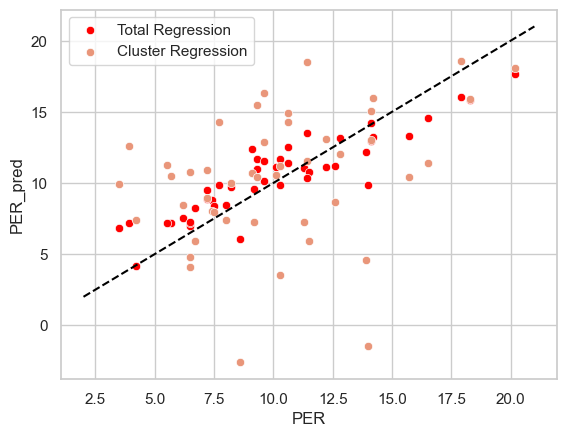

In [310]:
sns.scatterplot(x=rkcl3["PER"], y=rkcl3["PER_pred"], label="Total Regression",color='red')
sns.scatterplot(x=rookies_cluster3["PER"],y=reg_t.predict(rookies_cluster3),label="Cluster Regression",color="DarkSalmon")

plt.plot([2, 21],[2, 21],linestyle='--', color='black', label='Bisector')
plt.show()